## Imports

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np

from src.database import *
from src.nist import get_reference_NIST_values
from src.tools import calc_error

import matplotlib.pyplot as plt
plt.style.use('custom_matplotlibrc')
plt.rcParams["figure.figsize"] = (10,10)
fig_id = 0

## Configurations

In [2]:
database_path = Path('databases/3T_NIST_T1maps_database.pkl')
output_folder = Path("plots/03_singledataset_scatter_NIST/")

## Define functions

In [3]:
def plot_single_scatter(x, y, y_std,
                        title, x_label, y_label,
                        file_prefix, folder_path, fig_id,
                        y_type='linear'):
    if y_type is 'linear':
        plt.errorbar(x,y, y_std, fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
    if y_type is 'log':
        plt.loglog(x,y,'o')
        ax = plt.gca()
        ax.set_ylim(ymin=20)
        ax.set_xlim(xmin=20)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y), fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
    
    plt.title(title, fontsize=30)
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)

    fig = plt.gcf()
    

    folder_path.mkdir(parents=True, exist_ok=True)

    if fig_id<10:
        filename = "0" + str(fig_id) + "_" + file_prefix
    else:
        filename = str(fig_id) + "_" + file_prefix

    fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
    fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
    fig_id = fig_id + 1
    plt.show()
    return fig_id

## Load database

In [4]:
df = pd.read_pickle(database_path)

## Initialize variables, store mean and standard deviations of T1 in the ROIs

In [5]:
dataset_mean = np.array([])
dataset_std = np.array([])

index = 6.001

version = df.loc[index]['phantom serial number']

dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 1']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 2']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 3']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 4']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 5']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 6']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 7']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 8']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 9']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 10']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 11']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 12']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 13']))
dataset_mean = np.append(dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 14']))


dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 1']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 2']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 3']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 4']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 5']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 6']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 7']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 8']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 9']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 10']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 11']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 12']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 13']))
dataset_std = np.append(dataset_std, np.std(df.loc[index]['T1 - NIST sphere 14']))


ref_values = get_reference_NIST_values(version)

## Plot figures

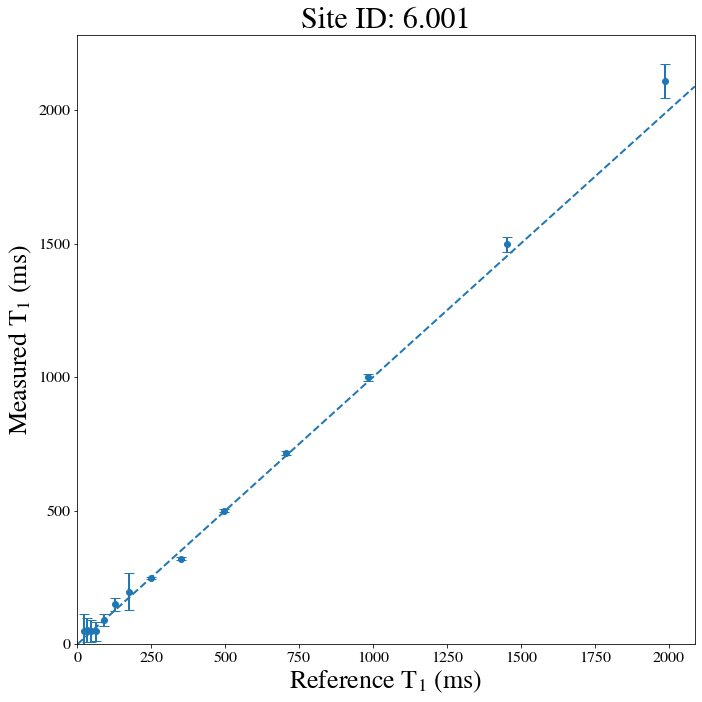

In [6]:
fig_id = plot_single_scatter(x=ref_values,
                             y=dataset_mean,
                             y_std=dataset_std,
                             title='Site ID: '+ str(index),
                             x_label='Reference T$_1$ (ms)',
                             y_label="Measured T$_1$ (ms)",
                             file_prefix=str(index),
                             folder_path=output_folder,
                             fig_id=fig_id,
                             y_type='linear')

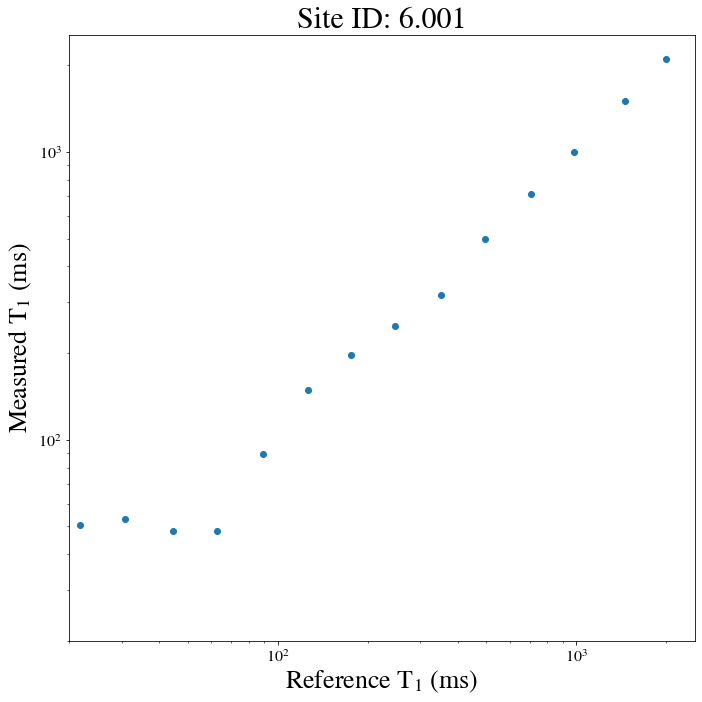

In [7]:
fig_id = plot_single_scatter(x=ref_values,
                             y=dataset_mean,
                             y_std=dataset_std,
                             title='Site ID: '+ str(index),
                             x_label='Reference T$_1$ (ms)',
                             y_label="Measured T$_1$ (ms)",
                             file_prefix=str(index),
                             folder_path=output_folder,
                             fig_id=fig_id,
                             y_type='log')

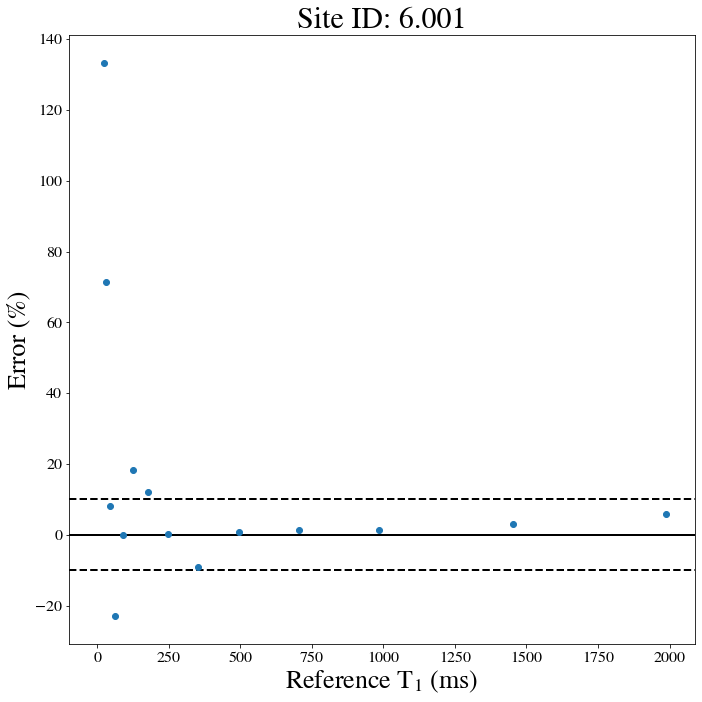

In [8]:
fig_id = plot_single_scatter(x=ref_values,
                             y=dataset_mean,
                             y_std=dataset_std,
                             title='Site ID: '+ str(index),
                             x_label='Reference T$_1$ (ms)',
                             y_label="Error (%)",
                             file_prefix=str(index),
                             folder_path=output_folder,
                             fig_id=fig_id,
                             y_type='error_t1')